In [24]:
import sys
from pathlib import Path

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

project_root = Path("..").resolve()
sys.path.append(str(project_root))

In [25]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


In [26]:
attack_transform = transforms.ToTensor()

test_dataset = datasets.MNIST(
    root="../data/raw",
    train=False,
    download=False,
    transform=attack_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

print("Test samples:", len(test_dataset))

Test samples: 10000


In [27]:
from models.mnist_cnn import MNISTCNN

model = MNISTCNN()
model.load_state_dict(torch.load("../models/mnist_cnn.pt", map_location=device))
model = model.to(device)
model.eval()

print("Model loaded and ready.")

Model loaded and ready.


In [28]:
def evaluate(model, loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)

    return correct / total

clean_acc = evaluate(model, test_loader)
print("Clean test accuracy:", clean_acc)

Clean test accuracy: 0.9861


In [29]:
from art.estimators.classification import PyTorchClassifier

classifier = PyTorchClassifier(
    model=model,
    loss=nn.CrossEntropyLoss(),
    optimizer=None,
    input_shape=(1, 28, 28),
    nb_classes=10,
    clip_values=(0.0, 1.0),
    device_type="cpu"
)

print("ART classifier ready.")

ART classifier ready.


In [30]:
from art.attacks.evasion import FastGradientMethod

attack = FastGradientMethod(
    estimator=classifier,
    eps=0.3
)

x_test, y_test = next(iter(test_loader))
x_test_np = x_test.numpy()

x_adv = attack.generate(x=x_test_np)

print("Adversarial samples generated.")

Adversarial samples generated.


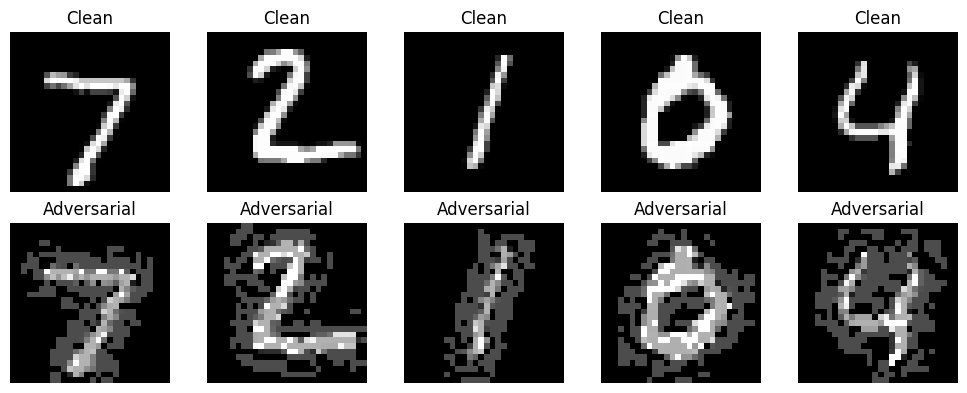

In [31]:
plt.figure(figsize=(10, 4))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i][0], cmap="gray")
    plt.title("Clean")
    plt.axis("off")

    plt.subplot(2, 5, i + 6)
    plt.imshow(x_adv[i][0], cmap="gray")
    plt.title("Adversarial")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [32]:
x_adv_tensor = torch.tensor(
    x_adv,
    dtype=torch.float32
)

y_test_tensor = y_test

with torch.no_grad():
    outputs = model(x_adv_tensor)
    preds = outputs.argmax(dim=1)
    adv_acc = (preds == y_test_tensor).float().mean().item()

print("Adversarial accuracy (FGSM):", adv_acc)

Adversarial accuracy (FGSM): 0.03125


In [33]:
np.save("../data/processed/x_adv_fgsm.npy", x_adv)
np.save("../data/processed/y_adv_fgsm.npy", y_test.numpy())

print("Adversarial dataset saved to data/processed/")

Adversarial dataset saved to data/processed/
